## Pawpularity Transfer Learning Approach in Pytorch

This notebook implements a resnet50 architecture with pre-trained weights, replacing the final layer and re-training the last convlutional layer set to predict a pawpularity score bounded between 0 and 100.  Everything is implemented from scratch in pytorch.  


- A custom pytorch dataset class is implemented to attach scores to each image file, as well as the annotations.  Currently only the images are being used to train the model.  
- The model is a resnet50 architectur where the final fully connected layer is replaced with two fully connected layers and output 1 value.
- The model starts with pretrained weights for all of the convolutional layers, and the final set of layers in the model (layer4) is unfrozen to allow it to learn a feature representation more specifi to this task.  Training refreezes layer4 after 4 epochs and continues to only train the fully connected layers after that to reduce overfitting.  
- The final activation is sigmoid to bound the output between 1 and 0, and output is multiplied by 100 in the training loop to give it a bounded output between 0 and 100 which matches the range of pawpularity scores.  
- The model is optimising for mean squared error(MSE), using Adam with weight decay to reduce overfitting.
- The final competition evaluation metric is the square root of MSE or 
$ \textrm{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2} $


### Load Dependencies

In [1]:
conda install anaconda::pandas


CondaHTTPError: HTTP 000 CONNECTION FAILED for url <https://conda.anaconda.org/conda-forge/linux-64/current_repodata.json>
Elapsed: -

An HTTP error occurred when trying to retrieve this URL.
HTTP errors are often intermittent, and a simple retry will get you on your way.
'https//conda.anaconda.org/conda-forge/linux-64'



Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import math
import time
import os
import pickle
# from skimage import io, transform
from pathlib import Path
import PIL
from sklearn.metrics import f1_score,precision_score,recall_score

ModuleNotFoundError: No module named 'pandas'

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms, models

from torch import nn, optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler

In [3]:
# Config
data_dir = 'E:\\AI\\sem3\\FAPS\\dataset\\PA_Jakob_Roser_Datentrager\\06_Datensatze\\01_Images\\Images_3000x1500'
model_dir = '../input/resnet50-pretrained-model/'



working_dir = './'
global_batch_size = 64
workers = 2
np.random.seed(10)
# print(os.listdir(data_dir))
# print(os.listdir(f'{data_dir}train')[0:4])

### Load and Explore data

**Look at the annotations**

In [4]:
def read_split():
    split_dir = './splits/PA_M/'
    split = 0
    with open(f'{split_dir}split_{split}_D2.pyb', "rb") as f:
        vals = pickle.load(f)
    return vals

In [5]:
train_pos_path,test_pos_path,train_seg_path,test_seg_path,train_neg_path,test_neg_path,train_y_vals,test_y_vals,val_pos_path,val_seg_path,val_neg_path,val_y_vals = read_split()

**Custom dataset class to attach annotations and scores to the images**

This is a critical step to attach the classes and annotations to the image files and allow this to be put into a pytorch dataloader.  

In [10]:
train_path = []
_train_path = train_pos_path + train_neg_path
for p in _train_path:  
    full_name = Path(p).name
    train_path.append(os.path.join(data_dir,full_name))

val_path = []    
_val_path = val_pos_path + val_neg_path
for p in _val_path: 
    full_name = Path(p).name
    val_path.append(os.path.join(data_dir,full_name))
    
test_path = []    
_test_path = test_pos_path + test_neg_path
for p in _test_path:  
    full_name = Path(p).name
    test_path.append(os.path.join(data_dir,full_name))

In [11]:
for p in train_path:
    
    # load each image in PIL format for compatibility with transforms
    image = PIL.Image.open(p)
    print(p,image.size)

E:\AI\sem3\FAPS\dataset\PA_Jakob_Roser_Datentrager\06_Datensatze\01_Images\Images_3000x1500\601.jpg (3000, 1500)
E:\AI\sem3\FAPS\dataset\PA_Jakob_Roser_Datentrager\06_Datensatze\01_Images\Images_3000x1500\603.jpg (3000, 1500)
E:\AI\sem3\FAPS\dataset\PA_Jakob_Roser_Datentrager\06_Datensatze\01_Images\Images_3000x1500\604.jpg (3000, 1500)
E:\AI\sem3\FAPS\dataset\PA_Jakob_Roser_Datentrager\06_Datensatze\01_Images\Images_3000x1500\606.jpg (3000, 1500)
E:\AI\sem3\FAPS\dataset\PA_Jakob_Roser_Datentrager\06_Datensatze\01_Images\Images_3000x1500\607.jpg (3000, 1500)
E:\AI\sem3\FAPS\dataset\PA_Jakob_Roser_Datentrager\06_Datensatze\01_Images\Images_3000x1500\608.jpg (3000, 1500)
E:\AI\sem3\FAPS\dataset\PA_Jakob_Roser_Datentrager\06_Datensatze\01_Images\Images_3000x1500\609.jpg (3000, 1500)
E:\AI\sem3\FAPS\dataset\PA_Jakob_Roser_Datentrager\06_Datensatze\01_Images\Images_3000x1500\610.jpg (3000, 1500)
E:\AI\sem3\FAPS\dataset\PA_Jakob_Roser_Datentrager\06_Datensatze\01_Images\Images_3000x1500\611.

In [12]:
train_labels = np.vstack([np.zeros((420,12)),train_y_vals])
val_labels = np.vstack([np.zeros((60,12)),val_y_vals])
test_labels = np.vstack([np.zeros((120,12)),test_y_vals])

In [13]:
class Dataset(Dataset):
    """Dataset connecting animal images to the score and annotations"""

    def __init__(self, labels, img_dir, transform=transforms.ToTensor()):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            img_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """

#         self.annotations_csv = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.annotation = labels

    def __len__(self):
        return len(self.annotation)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.img_dir[idx]

        # load each image in PIL format for compatibility with transforms
        image = PIL.Image.open(img_name)
        
        # Columns 1 to 12 contain the annotations
        annotations = self.annotation.astype('float')[idx]

        # Apply the transforms
        image = self.transform(image)

        sample = [image, annotations]
        return sample

**Define global image transforms**

In [14]:
# Test out the transforms on an image (images need to be made the same size for the dataset to work)
# Apply some image augmentation on the training set (rotation, flip)
# Normalize using imagenet RGB mean and std

img_transforms = transforms.Compose([transforms.Resize((255,255)),
#                                      transforms.CenterCrop(224),
                                     transforms.RandomHorizontalFlip(),
#                                      transforms.RandomRotation(20),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])])

img_transforms_valid = transforms.Compose([transforms.Resize((255,255)),
#                                            transforms.CenterCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                std=[0.229, 0.224, 0.225])])

**Load and check out the datasets**

In [15]:
## Load and set up the final training and validation dataset (use different transforms)

train_data = Dataset(train_labels,train_path, transform=img_transforms)
valid_data = Dataset(val_labels,val_path, transform=img_transforms_valid)

np.random.seed(13)

# obtain random indices that will be used for traingin/validation split


train_loader = torch.utils.data.DataLoader(train_data, batch_size=global_batch_size)
# sample the validation dataset from a separate dataset the doesn't include the image aug transformations.
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=global_batch_size)

print(len(train_loader)*global_batch_size)
print(len(valid_loader)*global_batch_size)

704
128


In [16]:
for data_point in train_loader:
    data_point 
    break

In [17]:
# Batch size of 8
images, annotations = next(iter(train_loader))
print(images.shape)

print(annotations.shape)

torch.Size([64, 3, 255, 255])
torch.Size([64, 12])


**Look at some images**

In [18]:
# Helper function to unnormalize and plot images
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image * np.array((0.229, 0.224, 0.225)).reshape(3, 1, 1) + np.array((0.485, 0.456, 0.406)).reshape(3, 1, 1)
    img = (image * 255).astype(np.uint8) # unnormalize
    

    return plt.imshow(np.transpose(img, (1, 2, 0)))

ValueError: only one element tensors can be converted to Python scalars

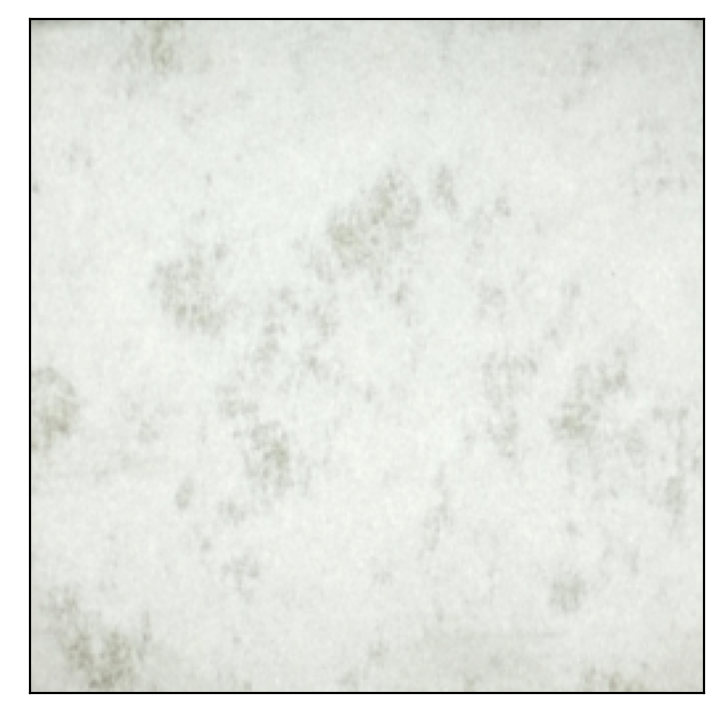

In [19]:
im_numpy = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 10))
# display 20 images
for idx in np.arange(8):
    ax = fig.add_subplot(2, 4, idx+1, xticks=[], yticks=[])
    im_convert(images[idx])
    ax.set_title(annotations[idx].item())

### Set up the model structure

In [20]:
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optim

**Downloading the pretrained model**

To access the pretrained model in a kaggle notebook, download it via pytorch on a local notebook, save the model using torch.save.  Then upload it to your kaggle notebook as a dataset which you can then load via torch.load without having to connect to the internet.

In [21]:
model = models.resnet50(pretrained=True)
torch.save(model, 'resnet50_pretrained.pt')

**Load the model, replace the output layer, and choose which layers to freeze/train**

In [22]:
# Load the pretrained resnet50
model = torch.load('resnet50_pretrained.pt')

# Disable gradients on all model parameters to freeze the weights
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected resnet layer with a 2 fc layer network and sigmoid output
model.fc = nn.Sequential(nn.Linear(2048, 256),
                         nn.ReLU(),
                         nn.Linear(256, 12),
                         nn.Sigmoid())

for param in model.fc.parameters():
    param.requires_grad = True
    
# Unfreeze the last few layers of the model

for param in model.layer4.parameters():
    param.requires_grad = True

In [23]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [24]:
torch.manual_seed(13)

criterion = nn.BCEWithLogitsLoss(reduction='mean')

#Adam with L2 regularization
optimizer = optim.AdamW(model.parameters(), lr=0.000025, weight_decay=50)

# Learning rate decay
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones = [1, 2, 6], gamma=0.5)

In [25]:
# Test out the forward pass on a single batch

images, annotations = next(iter(train_loader))
with torch.no_grad():
    train_loss = 0.0
    output = model(images) # convert sigmoid output to pawpularity scale
    loss = criterion(output, annotations)
    
#     math.sqrt(loss.item()/global_batch_size)

np_out = output.numpy()
np_an = annotations.numpy()
fscore = f1_score(np_out >0.5 , np_an, average = None)

print('Fscore: ', fscore)
print('Prediction Standard Deviation: ', np_out)

Fscore:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Prediction Standard Deviation:  [[0.483487   0.5211022  0.5031358  0.4278794  0.49121895 0.4792172
  0.52609926 0.4399706  0.5409343  0.5150941  0.49352825 0.4905426 ]
 [0.47293922 0.5121789  0.490706   0.42104307 0.49812433 0.46161377
  0.5311993  0.43345204 0.56113356 0.5198046  0.5141677  0.46514544]
 [0.47662967 0.50077844 0.50325596 0.41189075 0.5151438  0.47277343
  0.52428716 0.45375365 0.5864592  0.49151433 0.51071155 0.48126605]
 [0.47577804 0.5267199  0.493321   0.4186259  0.48079637 0.48647383
  0.48831612 0.45416296 0.55085677 0.51907164 0.4861976  0.51353437]
 [0.48951575 0.51913226 0.49637216 0.4295143  0.49408123 0.46530026
  0.5255563  0.4407755  0.54626846 0.5181515  0.5184439  0.5015602 ]
 [0.49262628 0.5233999  0.50223315 0.43091568 0.49913248 0.487211
  0.5328427  0.45593482 0.5724411  0.520305   0.5054928  0.5016366 ]
 [0.46906897 0.51681924 0.48896357 0.41547722 0.51077557 0.48707986
  0.5212128  0.43714017 0.54831797

C:\Users\vaish\anaconda3\envs\MSSurface\lib\site-packages\sklearn\metrics\_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


### Train the model

In [26]:
# check if CUDA is available and set the training device

train_on_gpu = torch.cuda.is_available()
device = torch.cuda.get_device_name()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print(f'CUDA is available!  Training on GPU {device}...')

CUDA is available!  Training on GPU NVIDIA GeForce GTX 1650...


**Model training loop**

Run the training and validation steps for a fixed number of epochs, and save the model anytime the validation loss decreases.  

In [27]:
# Training and validation loop

if train_on_gpu:
    model.cuda()

n_epochs = 100

valid_loss_min = np.Inf # track change in validation loss

train_losses, valid_losses = [], []

for epoch in range(1, n_epochs+1):
    
    start = time.time()
    current_lr = scheduler.get_last_lr()[0]
    
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # Stop training the convolutional layers after a certain point
    if epoch > 3:
        for param in model.layer4.parameters():
            param.requires_grad = False
    
    ###################
    # train the model #
    ###################
    # put in training mode (enable dropout)
    model.train()
    for images, annotations in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            images, annotations = images.cuda(), annotations.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(images) # multiply by 100 the sigmoid output to 0-100 pawpularity scale
        # print(output.dtype)
        # print(scores.dtype)
        # calculate the batch loss
        loss = criterion(output, annotations)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()
        
    ######################    
    # validate the model #
    ######################
    # eval mode (no dropout)
    if epoch%5 ==0:
        
        model.eval()
        with torch.no_grad():
            for images, annotations in valid_loader:
                # move tensors to GPU if CUDA is available
                if train_on_gpu:
                    images, annotations = images.cuda(), annotations.cuda()
                # forward pass: compute predicted outputs by passing inputs to the model
                output = model(images) # multiply by 100 the sigmoid output to 0-100 pawpularity scale
                # calculate the batch loss
                loss = criterion(output, annotations)
                # update average validation loss 
                valid_loss += loss.item()
                
        valid_losses.append(valid_loss)
    
        print('Epoch: {}, time: {:.1f}s, lr: {:.7f} \tTraining Loss: {:.3f} \tValidation Loss: {:.3f}'.format(
            epoch, float(time.time() - start), current_lr, train_loss, valid_loss))

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.3f} --> {:.3f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), f'{working_dir}pawpularity_best_model.pt')
            valid_loss_min = valid_loss  
            
    # calculate RMSE
#     train_loss = math.sqrt(train_loss/len(train_loader.sampler)
#     valid_loss = math.sqrt(valid_loss/len(valid_loader.sampler))
    
    train_losses.append(train_loss)
        
        
    # increment learning rate decay
    scheduler.step()
    
    # print training/validation statistics 
    # print(f'Epoch: {e}, {float(time.time() - start):.3f} seconds, lr={optimizer.lr}')
 

Epoch: 5, time: 50.6s, lr: 0.0000063 	Training Loss: 9.560 	Validation Loss: 1.717
Validation loss decreased (inf --> 1.717).  Saving model ...
Epoch: 10, time: 52.1s, lr: 0.0000031 	Training Loss: 9.286 	Validation Loss: 1.674
Validation loss decreased (1.717 --> 1.674).  Saving model ...
Epoch: 15, time: 55.5s, lr: 0.0000031 	Training Loss: 9.104 	Validation Loss: 1.643
Validation loss decreased (1.674 --> 1.643).  Saving model ...
Epoch: 20, time: 54.8s, lr: 0.0000031 	Training Loss: 8.947 	Validation Loss: 1.617
Validation loss decreased (1.643 --> 1.617).  Saving model ...
Epoch: 25, time: 56.8s, lr: 0.0000031 	Training Loss: 8.809 	Validation Loss: 1.593
Validation loss decreased (1.617 --> 1.593).  Saving model ...
Epoch: 30, time: 57.2s, lr: 0.0000031 	Training Loss: 8.687 	Validation Loss: 1.573
Validation loss decreased (1.593 --> 1.573).  Saving model ...
Epoch: 35, time: 57.3s, lr: 0.0000031 	Training Loss: 8.580 	Validation Loss: 1.555
Validation loss decreased (1.573 --> 

### Diagnostics and performance

In [28]:
# Load the best performing model on the validation set
model.load_state_dict(torch.load(f'{working_dir}pawpularity_best_model.pt'))

<All keys matched successfully>

In [29]:
# get the distribution of predictions

predictions = []
annotations_list = []

model.eval()
with torch.no_grad():
    for images, annotations in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            images, annotations = images.cuda(), annotations.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(images)
        predictions.extend(output.cpu().detach().numpy())
        annotations_list.extend(annotations.cpu().detach().numpy())
        

preds_df = pd.DataFrame({'preds': predictions})
preds_df.describe()

,preds
count,96
unique,96
top,"[0.0560945, 0.10304144, 0.093678296, 0.0982207..."
freq,1


In [30]:
output.shape

torch.Size([32, 12])

In [31]:
np.float32(predictions).max()

0.1414937

(array([149.,  40., 128., 270., 297.,  67.,  46., 132.,  19.,   4.]),
 array([0.04934148, 0.05826982, 0.06719816, 0.07612651, 0.08505485,
        0.0939832 , 0.10291155, 0.11183989, 0.12076823, 0.12969658,
        0.13862492], dtype=float32),
 <a list of 10 Patch objects>)

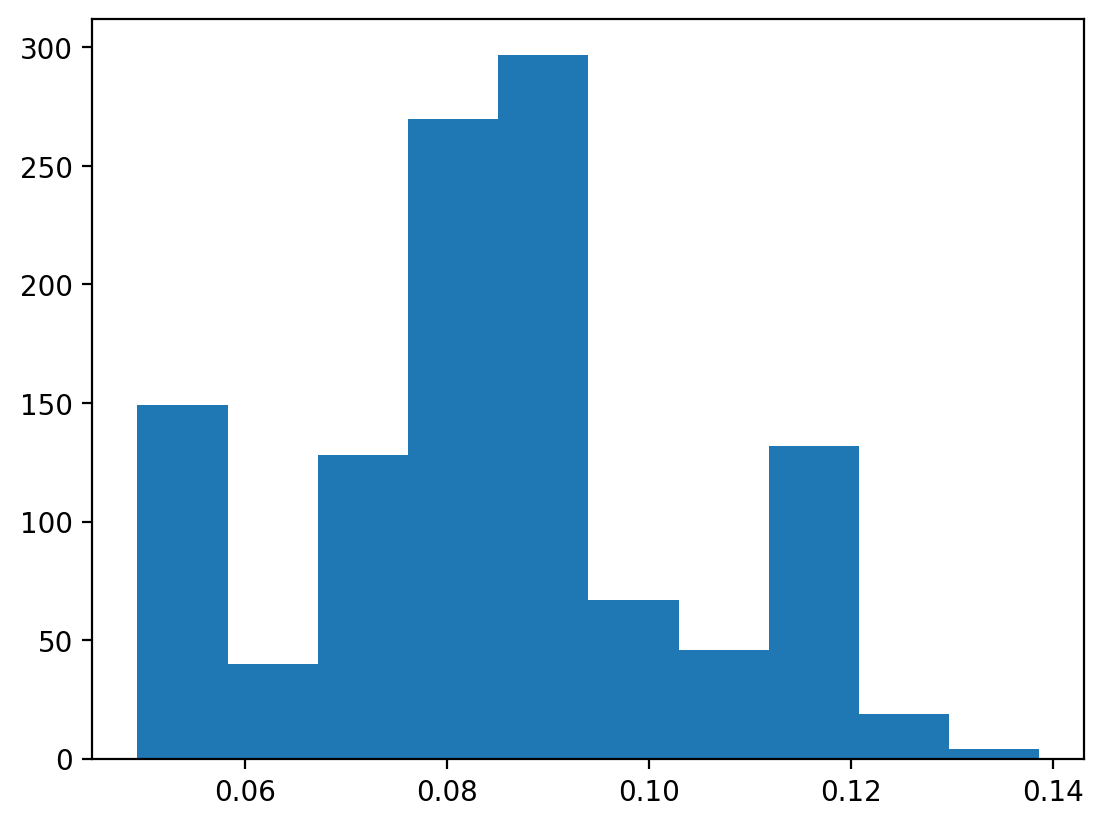

In [138]:
plt.hist(np.float32(predictions).reshape(-1))

In [141]:
# Manually Check RMSE

fscore = f1_score(np.float32(predictions) > 0.05 , annotations_list, average = 'macro')
print(fscore)


0.0991438555620268


In [ ]:
# Check that manually increasing the variance doesn't help

mean = np.mean(np.array(predictions))
stddev = np.std((np.array(predictions)))
print(mean, stddev)
updated_normalized = 1.5*(predictions-mean)/stddev
new_predictions = updated_normalized+predictions

diffs = np.array(score_list) - np.array(new_predictions)
print(math.sqrt((diffs @ diffs)/len(valid_loader.sampler)))

In [ ]:
# Histogram of validation predictions - if this is too narrow that's an issue

n, bins, patches = plt.hist(predictions, 50, density=True, facecolor='g', alpha=0.75)

plt.xlabel('Pawpularity')
plt.ylabel('Frequency')
plt.title('Predicted Pawpularity Histogram')
plt.xlim(0, 100)
plt.ylim(0, .2)
plt.grid(True)
plt.show()

The range could still be a greater, and the model is failing completely at predicting the highest ranked images that get a score of 100.  That said, it is producing a much higher range of predictions than the and feels like it would give useful information to users submitting photos.  

In [ ]:
# Histogram of validation set actual scores

n, bins, patches = plt.hist(train_df.iloc[valid_idx, 13], 50, density=True, facecolor='g', alpha=0.75)

plt.xlabel('Pawpularity')
plt.ylabel('Frequency')
plt.title('Actual Pawpularity Histogram')
plt.xlim(0, 100)
plt.ylim(0, .2)
plt.grid(True)
plt.show()

In [ ]:
# Plot the losses
fig = plt.figure()
ax = plt.axes()
ax.plot(list(range(1, len(train_losses))), train_losses[1:])
ax.plot(list(range(1, len(valid_losses))), valid_losses[1:]);
print(f'best score: {valid_loss_min}')

### Show examples of images and predicted vs. actual scores

In [ ]:
images, annotations, scores = next(iter(valid_loader))
images, annotations, scores = images.cuda(), annotations.cuda(), scores.cuda()

In [ ]:
output_plot = model(images).cpu()*100
images, annotations, scores = images.cpu(), annotations.cpu(), scores.cpu()

In [ ]:
# plot the images in the batch, along with the corresponding labels and predictions

fig = plt.figure(figsize=(20, 10))
# display 20 images
for idx in np.arange(12):
    ax = fig.add_subplot(3, 4, idx+1, xticks=[], yticks=[])
    im_convert(images[idx])
    ax.set_title(f'Act: {round(scores[idx].item())} Pred: {round(output_plot[idx].item())}')

### Use the model to predict the test dataset

In [ ]:
test_df = pd.read_csv(f'{data_dir}test.csv')
test_df.head(10)

In [ ]:
# Load the best performing model on the validation set
model.load_state_dict(torch.load('pawpularity_best_model.pt'))

In [ ]:
class PawpularityTestDataset(Dataset):
    """Dataset connecting dog images to the score and annotations"""

    def __init__(self, csv_file, img_dir, transform=transforms.ToTensor()):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            img_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """

        self.annotations_csv = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations_csv)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.img_dir,
                                self.annotations_csv.iloc[idx, 0])

        # load each image in PIL format for compatibility with transforms
        image = PIL.Image.open(img_name + '.jpg')

        annotations = np.array(self.annotations_csv.iloc[idx, 1:13])
        annotations = annotations.astype('float')

        # Apply the transforms
        image = self.transform(image)

        sample = [image, annotations]
        return sample

In [ ]:
## Load the test dataset (careful to use validation transforms without img augmentation)

test_data = PawpularityTestDataset(f'{data_dir}test.csv', f'{data_dir}test', transform=img_transforms_valid)

batch_size = min(len(test_data), global_batch_size)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=workers) 

In [ ]:
# Step through with a reasonable batch size and build up the output dataset

model.eval()
outputs = []
for images, annotations in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        images, annotations = images.cuda(), annotations.cuda()
    test_output = model(images)*100
    outputs.extend(list(test_output.cpu().detach().numpy().reshape(len(test_output),)))
    
img_names = list( test_df.iloc[:, 0].values)
outputs = [round(x, 2) for x in outputs]

output_df = pd.DataFrame({'Id': img_names, 'Pawpularity': outputs})
output_df.head(10)

In [ ]:
# Write the output in the required format
output_df.to_csv('submission.csv', index=False)